# Example queries 

this notebook compares the diffrent datasources based on the queries defined in the example_queries.md

### Parameters and credentials

the code cell below defines the list of analyzed hashtags and the time range to be compared.
IMPORTANT do not forget to set the credentials for the individual databases.

In [2]:
# Hashtags should be case insensitive. This means that when you are adding `#missingmaps` or `#MissingMaps` or `#missingMaps` to a changeset comment this will all be counted towards lower case `missingmaps`. This is currently the case for the processing of the osmstats-api.
import os


hashtags = ['missingmaps', 'bloomberg','visa','hotosm-project-14154','hotosm-project-']
timerange = ["2022-01-01","2023-02-07"]

# credentials for the OSM-stats API

freq = "m"

#please make sure a valid .env file is provided. A default.env is provided.
from dotenv import load_dotenv
load_dotenv("../notebooks/dev.env")


True

In [3]:
import psycopg2 as ps 
from psycopg2._psycopg import connection
from pandas import DataFrame
import pandas as pd
import clickhouse_connect


def osmStatsQueryDataFrame(timerange:[str],hashtag:str,conn:connection,aggregator:str="COUNT(DISTINCT user_id)",grouper:[str]=["",""]):
    query = f"""SELECT {grouper[0]} {aggregator} FROM raw_changesets as raw WHERE (created_at BETWEEN '{timerange[0]}' AND '{timerange[1]}') AND raw.id in 
                (SELECT changeset_id FROM raw_changesets_hashtags as hsh where hsh.hashtag_id in 
                (SELECT id FROM raw_hashtags as rh WHERE LOWER(rh.hashtag) LIKE LOWER('{hashtag}%')))
                {grouper[1]}""" 
    df = pd.read_sql(query,con=conn)
    return  df

def changesetDbQueryDataFrame(timerange:[str],hashtag:str,conn:connection,aggregator:str="COUNT(DISTINCT user_id)",grouper:[str]=["",""]):
    query = f"""SELECT {grouper[0]} {aggregator} 
                FROM osm_changeset
                WHERE (LOWER(tags -> 'comment') LIKE '%#{hashtag}%' or LOWER(tags -> 'hashtags') LIKE LOWER('%#{hashtag}%'))
                AND (created_at BETWEEN '{timerange[0]}' AND '{timerange[1]}')
                {grouper[1]}"""
    
    df = pd.read_sql(query,con=conn)
    return  df
import clickhouse_connect

def ohsomeDbQueryDataFrame(timerange:[str],hastag:str,conn:clickhouse_connect.driver.httpclient.HttpClient,aggregator:str="COUNT(DISTINCT user_id)",grouper:[str]=["",""]):  
    query = f"""SELECT {grouper[0]} {aggregator}
                FROM stats_2
                WHERE LOWER(hashtag) LIKE LOWER('%#{hashtag}%') AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN '{timerange[0]}' AND '{timerange[1]}')
                {grouper[1]}"""
    res = conn.query_df(query)
    return res

In [4]:
import psycopg2 as ps 
from psycopg2._psycopg import connection
from pandas import DataFrame
import clickhouse_connect

def osmStatsQuery(timerange:[str],hashtag:str,conn:connection,aggregator:str="COUNT(DISTINCT user_id)"):
    query = f"""SELECT {aggregator} FROM raw_changesets as raw WHERE (created_at BETWEEN '{timerange[0]}' AND '{timerange[1]}') AND raw.id in 
                (SELECT changeset_id FROM raw_changesets_hashtags as hsh where hsh.hashtag_id in 
                (SELECT id FROM raw_hashtags as rh WHERE LOWER(rh.hashtag) LIKE LOWER('{hashtag}%')))""" 
    with conn.cursor() as cur:
        cur.execute(query)
        res = cur.fetchall()
    return res

def changesetDbQuery(timerange:[str],hashtag:str,conn:connection,aggregator:str="COUNT(DISTINCT user_id)"):
    query = f"""SELECT {aggregator} 
                FROM osm_changeset
                WHERE (LOWER(tags -> 'comment') LIKE '%#{hashtag}%' or LOWER(tags -> 'hashtags') LIKE LOWER('%#{hashtag}%'))
                AND (created_at BETWEEN '{timerange[0]}' AND '{timerange[1]}');
                """
    with conn.cursor() as cur:
        cur.execute(query)
        res = cur.fetchall()
    return res

def ohsomeDbQuery(timerange:[str],hastag:str,conn:clickhouse_connect.driver.httpclient.HttpClient,aggregator:str="COUNT(DISTINCT user_id)"):  
    query = f"""SELECT {aggregator}
                FROM stats_2
                WHERE LOWER(hashtag) LIKE LOWER('%#{hashtag}%') AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN '{timerange[0]}' AND '{timerange[1]}')"""
    
    res = conn.query(query)
    return res.result_set



## EQ1 Number of OSM Contributors

This is the number of distinct OSM users that contributed at least one changeset to a particular hashtag since the start of collecting data. This is the very first number displayed on the company leaderboards as `contributors`.

In [5]:
import pandas as pd
import traceback
data = []
with ps.connect(dbname=os.getenv("dbOSMSTATS"),user=os.getenv("userOSMSTATS"),host=os.getenv("hostOSMSTATS"),password=os.getenv("pwOSMSTATS"),port=os.getenv("portOSMSTATS")) as conn_mm:
    with clickhouse_connect.get_client(interface="https",user=os.getenv("userOHSOME"),host=os.getenv("hostOHSOME"),password=os.getenv("pwOHSOME"),port=os.getenv("portOHSOME")) as conn_ohsome:
        with ps.connect(dbname=os.getenv("dbCHDB"),user=os.getenv("userCHDB"),host=os.getenv("hostCHDB"),password=os.getenv("pwCHDB"),port=os.getenv("portCHDB")) as conn_chDB:
            aggregator = "COUNT(DISTINCT user_id) count"
            for hashtag in hashtags:
                entry = {"hashtag":hashtag,"timerange":timerange,"aggregator":aggregator}
                try:
                    countOSMSTATS = osmStatsQuery(timerange,hashtag,conn=conn_mm,aggregator=aggregator)[0][0]
                    entry["OSTMSTATS"]=countOSMSTATS
                except Exception:
                    print(traceback.format_exc())
                    print("failed OSMSTATS for hashtag: "+ hashtag)
                    pass
                try: 
                    countCHDB= changesetDbQuery(timerange,hashtag,conn=conn_chDB,aggregator=aggregator)[0][0]
                    entry["CHDB"]=countCHDB
                except Exception:
                    print(traceback.format_exc())
                    print("failed CHDB for hashtag: "+ hashtag)
                    pass
                try:
                    countOHSOME = ohsomeDbQuery(timerange,hashtag,conn=conn_ohsome,aggregator=aggregator)[0][0]
                    entry["OHSOME"]=countOHSOME
                except Exception:
                    print(traceback.format_exc())
                    print("failed OHSOME for hashtag: "+ hashtag)
                    pass
                data.append(entry)
result = pd.DataFrame.from_dict(data)
result.to_csv("../notebooks/queryResults/eq1.csv")
display(result)
              

,hashtag,timerange,aggregator,OSTMSTATS,CHDB,OHSOME
0,missingmaps,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT user_id) count,11636,11793,11774
1,bloomberg,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT user_id) count,550,572,572
2,visa,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT user_id) count,122,175,175
3,hotosm-project-14154,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT user_id) count,15,15,15
4,hotosm-project-,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT user_id) count,47970,48149,48045


## EQ2 Number of OSM Changesets

This is the number of distinct OSM changesets contributed to a particular hashtag since the start of collecting data. This number is of less important for partners or reporting at mapathons and often this causes confusion.

However, internally this number will be helpful to compare different processing approaches.

In [6]:
import pandas as pd
import traceback
data = []
with ps.connect(dbname=os.getenv("dbOSMSTATS"),user=os.getenv("userOSMSTATS"),host=os.getenv("hostOSMSTATS"),password=os.getenv("pwOSMSTATS"),port=os.getenv("portOSMSTATS")) as conn_mm:
    with clickhouse_connect.get_client(interface="https",user=os.getenv("userOHSOME"),host=os.getenv("hostOHSOME"),password=os.getenv("pwOHSOME"),port=os.getenv("portOHSOME")) as conn_ohsome:
        with ps.connect(dbname=os.getenv("dbCHDB"),user=os.getenv("userCHDB"),host=os.getenv("hostCHDB"),password=os.getenv("pwCHDB"),port=os.getenv("portCHDB")) as conn_chDB:
            for hashtag in hashtags:
                entry = {"hashtag":hashtag,"timerange":timerange,"aggregator":aggregator}
                try:
                    aggregator = "COUNT(DISTINCT id) count"
                    countOSMSTATS = osmStatsQuery(timerange,hashtag,conn=conn_mm,aggregator=aggregator)[0][0]
                    entry["OSTMSTATS"]=countOSMSTATS
                except Exception:
                    print(traceback.format_exc())
                    print("failed OSMSTATS for hashtag: "+ hashtag)
                    pass
                try:
                    aggregator = "COUNT(DISTINCT id) count"
                    countCHDB= changesetDbQuery(timerange,hashtag,conn=conn_chDB,aggregator=aggregator)[0][0]
                    entry["CHDB"]=countCHDB
                except Exception:
                    print(traceback.format_exc())
                    print("failed CHDB for hashtag: "+ hashtag)
                    pass
                try:
                    aggregator = "COUNT(DISTINCT changeset_id) count"
                    countOHSOME = ohsomeDbQuery(timerange,hashtag,conn=conn_ohsome,aggregator=aggregator)[0][0]
                    entry["OHSOME"]=countOHSOME
                except Exception:
                    print(traceback.format_exc())
                    print("failed OHSOME for hashtag: "+ hashtag)
                    pass
                data.append(entry)
result = pd.DataFrame.from_dict(data)
result.to_csv("../notebooks/queryResults/eq2.csv")
display(result)


,hashtag,timerange,aggregator,OSTMSTATS,CHDB,OHSOME
0,missingmaps,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT user_id) count,291969,293747,292483
1,bloomberg,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT changeset_id) count,7935,8091,8055
2,visa,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT changeset_id) count,1230,1821,1820
3,hotosm-project-14154,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT changeset_id) count,108,108,108
4,hotosm-project-,"[2022-01-01, 2023-02-07]",COUNT(DISTINCT changeset_id) count,1354439,1361236,1352537


## road lenght edited

In [17]:
import pandas as pd
import traceback
data = []
with ps.connect(dbname=os.getenv("dbOSMSTATS"),user=os.getenv("userOSMSTATS"),host=os.getenv("hostOSMSTATS"),password=os.getenv("pwOSMSTATS"),port=os.getenv("portOSMSTATS")) as conn_mm:
    with clickhouse_connect.get_client(interface="https",user=os.getenv("userOHSOME"),host=os.getenv("hostOHSOME"),password=os.getenv("pwOHSOME"),port=os.getenv("portOHSOME")) as conn_ohsome:
        with ps.connect(dbname=os.getenv("dbCHDB"),user=os.getenv("userCHDB"),host=os.getenv("hostCHDB"),password=os.getenv("pwCHDB"),port=os.getenv("portCHDB")) as conn_chDB:
            for hashtag in hashtags:
                aggregator = "SUM((road_km_added + road_km_modiefied)*1000) count"
                entry = {"hashtag":hashtag,"timerange":timerange,"aggregator":aggregator}
                try:
                    aggregator = "SUM(road_km_added + road_km_modified) count"
                    countOSMSTATS = osmStatsQuery(timerange,hashtag,conn=conn_mm,aggregator=aggregator)[0][0]
                    entry["OSTMSTATS"]=countOSMSTATS
                except Exception:
                    print(traceback.format_exc())
                    print("failed OSMSTATS for hashtag: "+ hashtag)
                    pass
                try:
                    aggregator = "SUM(road_length_delta) count"
                    countOHSOME = ohsomeDbQuery(timerange,hashtag,conn=conn_ohsome,aggregator=aggregator)[0][0]
                    entry["OHSOME"]=countOHSOME
                except Exception:
                    print(traceback.format_exc())
                    print("failed OHSOME for hashtag: "+ hashtag)
                    pass
                data.append(entry)
                
result = pd.DataFrame.from_dict(data)
result.to_csv("../notebooks/queryResults/eq3.csv")
display(result)

,hashtag,timerange,aggregator,OSTMSTATS,OHSOME
0,missingmaps,"[2022-01-01, 2023-02-07]",SUM((road_km_added + road_km_modiefied)*1000) ...,64317.154702,4.804020e+07
1,bloomberg,"[2022-01-01, 2023-02-07]",SUM((road_km_added + road_km_modiefied)*1000) ...,215.733767,2.063048e+05
2,visa,"[2022-01-01, 2023-02-07]",SUM((road_km_added + road_km_modiefied)*1000) ...,0.390112,1.190952e+03
3,hotosm-project-14154,"[2022-01-01, 2023-02-07]",SUM((road_km_added + road_km_modiefied)*1000) ...,2.416767,1.255006e+03
4,hotosm-project-,"[2022-01-01, 2023-02-07]",SUM((road_km_added + road_km_modiefied)*1000) ...,340471.430772,2.529627e+08


# Querys per TimeInverval

## Cummulative sum of changesets by month

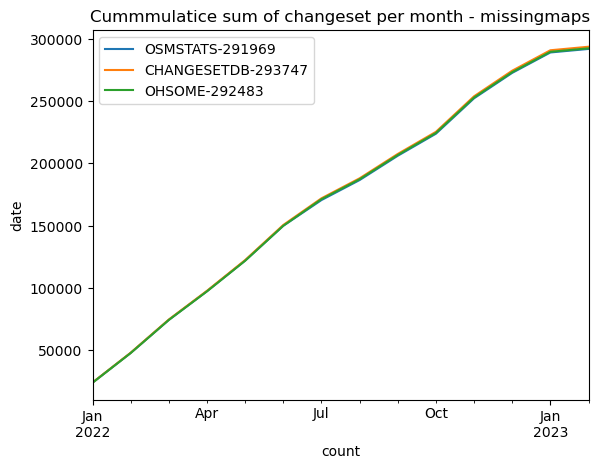

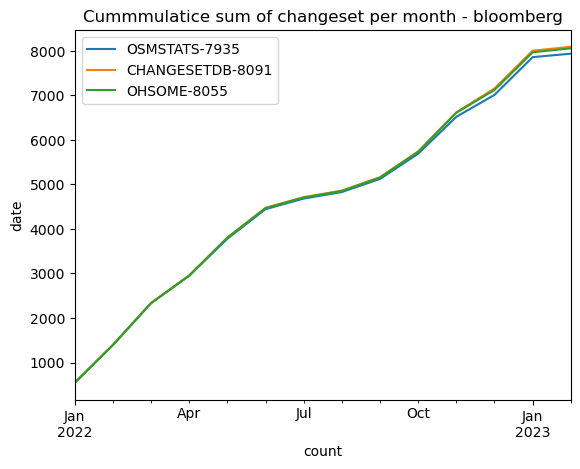

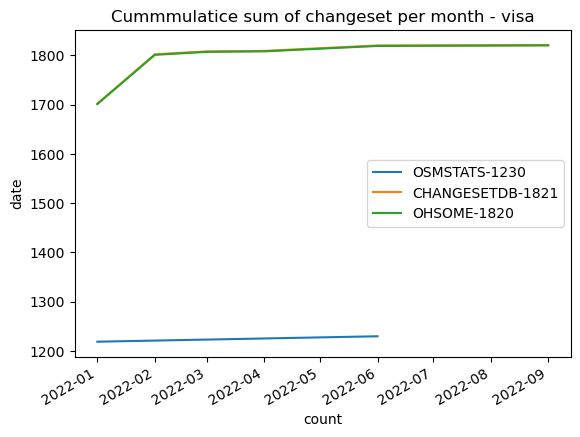

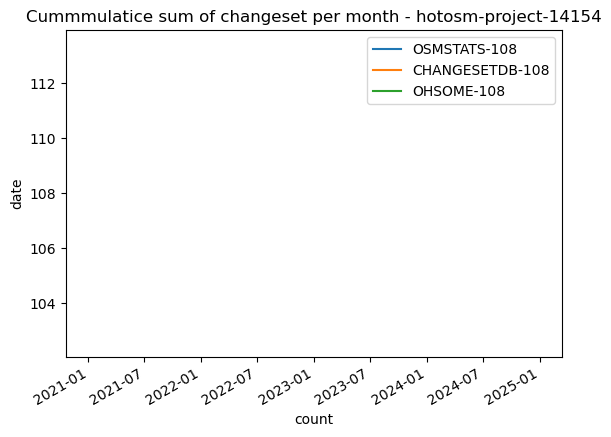

KeyboardInterrupt: 

In [10]:
import pandas as pd
import traceback
data = []

import matplotlib.pyplot as plt
def plot(dfs:[pd.DataFrame],hashtag):
    fig,ax = plt.subplots()
    labels = ["OSMSTATS","CHANGESETDB","OHSOME"]
    for i,df in enumerate(dfs):
        label = labels[i] + "-" +str(df["count"].sum()) 
        df["cumSum"].plot(ax=ax,label=label)
        
    plt.title(f'Cummmulatice sum of changeset per month - {hashtag}')
    plt.xlabel('count')
    plt.ylabel('date')
    plt.legend()
    plt.show()
def prepare(df):
    df = df.copy()
    df["date"] = df.apply(lambda x: str(int(x.year)) +"-" +str(int(x.month)) + "-1",axis=1)
    df.date = pd.to_datetime(df.date)
    df = df.set_index(pd.DatetimeIndex(df['date']))
    df = df.sort_index()
    df["cumSum"] = df["count"].cumsum()
    return df
    
with ps.connect(dbname=os.getenv("dbOSMSTATS"),user=os.getenv("userOSMSTATS"),host=os.getenv("hostOSMSTATS"),password=os.getenv("pwOSMSTATS"),port=os.getenv("portOSMSTATS")) as conn_mm:
    with clickhouse_connect.get_client(interface="https",user=os.getenv("userOHSOME"),host=os.getenv("hostOHSOME"),password=os.getenv("pwOHSOME"),port=os.getenv("portOHSOME")) as conn_ohsome:
        with ps.connect(dbname=os.getenv("dbCHDB"),user=os.getenv("userCHDB"),host=os.getenv("hostCHDB"),password=os.getenv("pwCHDB"),port=os.getenv("portCHDB")) as conn_chDB:
            for hashtag in hashtags:
                entry = {"hashtag":hashtag,"timerange":timerange,"aggregator":aggregator}
                aggregator = "COUNT(DISTINCT id) count"
                try:
                    grouper = ["EXTRACT(month FROM created_at) as month,EXTRACT(year FROM created_at) as year,","GROUP by month, year"]
                    countOSMSTATS = prepare(osmStatsQueryDataFrame(timerange,hashtag,conn=conn_mm,aggregator=aggregator,grouper=grouper))
                    entry["OSTMSTATS"]={"dates":[i.strftime('%Y-%m-%d') for i in countOSMSTATS.index.tolist()],"count":countOSMSTATS["cumSum"].tolist()}
                except Exception:
                    print(traceback.format_exc())
                    print("failed OSMSTATS for hashtag: "+ hashtag)
                    pass
                try:
                    countCHDB= prepare(changesetDbQueryDataFrame(timerange,hashtag,conn=conn_chDB,aggregator=aggregator,grouper=grouper))
                    entry["CHDB"]={"dates":[i.strftime('%Y-%m-%d') for i in countCHDB.index.tolist()],"count":countCHDB["cumSum"].tolist()}
                except Exception:
                    print(traceback.format_exc())
                    print("failed CHDB for hashtag: "+ hashtag)
                    pass
                try:
                    aggregator = "COUNT(DISTINCT changeset_id) count"
                    grouper = ["toMonth(fromUnixTimestamp((changeset_timestamp/1000)::integer)) as month,toYear(fromUnixTimestamp((changeset_timestamp/1000)::integer)) as year,","GROUP by month, year"]
                    countOHSOME = prepare(ohsomeDbQueryDataFrame(timerange,hashtag,conn=conn_ohsome,aggregator=aggregator,grouper=grouper))
                    entry["OHSOME"]={"dates":[i.strftime('%Y-%m-%d') for i in countCHDB.index.tolist()],"count":countCHDB["cumSum"].tolist()}
                except Exception:
                    print(traceback.format_exc())
                    print("failed OHSOME for hashtag: "+ hashtag)
                    pass
                data.append(entry)
                plot([countOSMSTATS,countCHDB,countOHSOME],hashtag)
import json


with open("../notebooks/queryResults/eq3.json", "w") as outfile:
    json.dump(data, outfile)




## WIP Cummulative of unique Users per month (only first appearance)

In [ ]:
import pandas as pd
import traceback
data = []

import matplotlib.pyplot as plt
def plot(dfs:[pd.DataFrame],hashtag):
    fig,ax = plt.subplots()
    labels = ["OSMSTATS","CHANGESETDB","OHSOME"]
    for i,df in enumerate(dfs):
        label = labels[i] + "-" +str(df["count"].sum()) 
        df["cumSum"].plot(ax=ax,label=label)
        
    plt.title(f'Cummmulatice sum of changeset per month - {hashtag}')
    plt.xlabel('count')
    plt.ylabel('date')
    plt.legend()
    plt.show()
def prepare(df):
    df = df.copy()
    df["date"] = df.apply(lambda x: str(int(x.year)) +"-" +str(int(x.month)) + "-1",axis=1)
    df.date = pd.to_datetime(df.date)
    df = df.set_index(pd.DatetimeIndex(df['date']))
    df = df.sort_index()
    df["cumSum"] = df["count"].cumsum()
    return df
    
with ps.connect(dbname=os.getenv("dbOSMSTATS"),user=os.getenv("userOSMSTATS"),host=os.getenv("hostOSMSTATS"),password=os.getenv("pwOSMSTATS"),port=os.getenv("portOSMSTATS")) as conn_mm:
    with clickhouse_connect.get_client(interface="https",user=os.getenv("userOHSOME"),host=os.getenv("hostOHSOME"),password=os.getenv("pwOHSOME"),port=os.getenv("portOHSOME")) as conn_ohsome:
        with ps.connect(dbname=os.getenv("dbCHDB"),user=os.getenv("userCHDB"),host=os.getenv("hostCHDB"),password=os.getenv("pwCHDB"),port=os.getenv("portCHDB")) as conn_chDB:
            for hashtag in [hashtags[-3]]:
                entry = {"hashtag":hashtag,"timerange":timerange,"aggregator":aggregator}
                aggregator = "COUNT(DISTINCT id) count"
                try:
                    grouper = ["EXTRACT(month FROM created_at) as month,EXTRACT(year FROM created_at) as year,","GROUP by month, year"]
                    countOSMSTATS = prepare(osmStatsQueryDataFrame(timerange,hashtag,conn=conn_mm,aggregator=aggregator,grouper=grouper))
                    entry["OSTMSTATS"]={"dates":countOSMSTATS.index.tolist(),"count":countOSMSTATS["cumSum"].tolist()}
                except Exception:
                    print(traceback.format_exc())
                    print("failed OSMSTATS for hashtag: "+ hashtag)
                    pass
                try:
                    countCHDB= prepare(changesetDbQueryDataFrame(timerange,hashtag,conn=conn_chDB,aggregator=aggregator,grouper=grouper))
                    entry["CHDB"]={"dates":countCHDB.index.tolist(),"count":countCHDB["cumSum"].tolist()}
                except Exception:
                    print(traceback.format_exc())
                    print("failed CHDB for hashtag: "+ hashtag)
                    pass
                try:
                    aggregator = "COUNT(DISTINCT changeset_id) count"
                    grouper = ["toMonth(fromUnixTimestamp((changeset_timestamp/1000)::integer)) as month,toYear(fromUnixTimestamp((changeset_timestamp/1000)::integer)) as year,","GROUP by month, year"]
                    countOHSOME = prepare(ohsomeDbQueryDataFrame(timerange,hashtag,conn=conn_ohsome,aggregator=aggregator,grouper=grouper))
                    entry["OHSOME"]={"dates":countCHDB.index.tolist(),"count":countCHDB["cumSum"].tolist()}
                except Exception:
                    print(traceback.format_exc())
                    print("failed OHSOME for hashtag: "+ hashtag)
                    pass
                data.append(entry)
                plot([countOSMSTATS,countCHDB,countOHSOME],hashtag)
import json


with open("../notebooks/queryResults/eq3.json", "w") as outfile:
    json.dump(data, outfile)